<a href="https://colab.research.google.com/github/aniket2405/TMAPaperCode/blob/getAvgDuration/get_avg_duration_code_TMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
## utils.py

import datetime as dt

import numpy as np
import pandas as pd
import pytz


def to_dataframe(obj, skip_na=True):
    df = pd.DataFrame.from_records(
        obj['results'],
        columns=obj['metadata']['schema']
    )
    df['dt'] = df.timestamp.apply(lambda x: dt.datetime.fromtimestamp(x, pytz.UTC))
    df.loc[df.status != 0, 'rtt'] = np.nan
    df.set_index('dt', inplace=True)
    if skip_na:
        df = df[df.rtt.first_valid_index():]
    return df


def get_segments(df):
    segments = []
    last_idx, last_state = 0, df.state[0]
    for i in range(1, len(df.state)):
        if (df.state[i] != df.state[i-1]) or (i == len(df.state)-1):
            segments.append({
                'start': last_idx,
                'stop': i,
                'state': last_state
            })
            last_idx, last_state = i, df.state[i]
    return segments


def compute_transition_matrix(seq):
    mapping = {x[1]: x[0] for x in enumerate(sorted(np.unique(seq)))}
    transmat = np.zeros((len(mapping), len(mapping)))
    for i in range(len(seq)-1):
        transmat[mapping[seq[i]], mapping[seq[i+1]]] += 1
    transmat = transmat / np.sum(transmat, axis=1)[:, np.newaxis]
    return mapping, transmat


def utc_datetime(*args):
    return dt.datetime(*args, tzinfo=pytz.UTC)


def td_format(td_object):
    """
    Python format timedelta to string
    https://stackoverflow.com/a/13756038
    """
    seconds = int(td_object.total_seconds())
    periods = [
        ('year',        60*60*24*365),
        ('month',       60*60*24*30),
        ('day',         60*60*24),
        ('hour',        60*60),
        ('minute',      60),
        # ('second',      1)
    ]

    strings = []
    for period_name, period_seconds in periods:
        if seconds > period_seconds:
            period_value, seconds = divmod(seconds, period_seconds)
            has_s = 's' if period_value > 1 else ''
            strings.append("%s %s%s" % (period_value, period_name, has_s))

    return ", ".join(strings)

In [86]:
## plot.py

import datetime as dt
import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pytz
import seaborn as sns
from matplotlib.dates import DateFormatter, HourLocator
from pandas.plotting import register_matplotlib_converters
from scipy.stats import gaussian_kde

#from .utils import *

register_matplotlib_converters()


def set_mpl_style(font_size=12):
    # Old seaborn versions (such as the one in Google Colab)
    # modify the default matplotlib style on import.
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        sns.reset_orig()

    plt.rc('figure', figsize=(18, 2.5))
    plt.rc('font', size=font_size)
    plt.rc('axes', titlesize=font_size)
    plt.rc('text', usetex=False)
    plt.rc('font', family='sans-serif')
    plt.rc('legend', frameon=False)


def plot_trends(df, legend=True, ax=None):
    if ax is None:
        ax = plt.gca()
    if 'rtt' in df:
        plot_rtt(df, ax=ax)
    if 'state' in df:
        plot_state(df, ax=ax)
    if legend:
        add_legend(df, ax=ax)


def plot_rtt(df, ax=None):
    if ax is None:
        ax = plt.gca()
    ax.plot(df.index, df.rtt, drawstyle='steps-mid', lw=1)
    ax.set_xlim(df.index.min(), df.index.max()+dt.timedelta(minutes=4))
    ax.set_ylabel('RTT (ms)')
    ax.xaxis.set_major_locator(HourLocator(byhour=0, tz=pytz.UTC))
    ax.xaxis.set_major_formatter(DateFormatter('%d %b', tz=pytz.UTC))


def plot_state(df, ax=None):
    if ax is None:
        ax = plt.gca()
    palette = sns.husl_palette(df.state.max(), l=0.7, s=.9)
    for segment in get_segments(df):
        start_dt = df.index[segment['start']]
        stop_dt = df.index[segment['stop']]
        color = palette[segment['state']-1]
        ax.axvspan(start_dt, stop_dt, alpha=0.3, color=color)


def add_legend(df, ax=None):
    if ax is None:
        ax = plt.gca()

    Δt = (df.index[1:] - df.index[:-1]).mean() / np.timedelta64(1, 's')
    mapping, transmat = compute_transition_matrix(df.state)

    palette = sns.husl_palette(df.state.max(), l=0.7, s=.9)
    artists, labels = [], []

    for state in sorted(df.state.unique()):
        # Ignore division by zero (handled later)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            avg_duration = (
                1 / (1 - transmat[mapping[state], mapping[state]])) * Δt

        if avg_duration == math.inf:
            avg_duration_str = '∞'
        else:
            avg_duration_str = td_format(dt.timedelta(seconds=avg_duration))

        #print(avg_duration_str)    

        artists.append(plt.Rectangle(
            (0, 0), 1, 1, color=palette[state-1], alpha=0.6))
        # labels.append('State {}\nAvg. duration\n{}'.format(
        #     state, avg_duration_str))
        labels.append('{}'.format(avg_duration_str))
        
    #print("new line")    
    print(labels)    

    # ax.legend(artists, labels, bbox_to_anchor=(
    #     0.5, -0.35), ncol=len(artists), loc='center')


def plot_kde(df, states=None):
    if states is None:
        states = df.state.unique()

    xmin, xmax = df.rtt.min(), df.rtt.max()
    X = np.arange(xmin-10, xmax+10, 0.1)
    palette = sns.husl_palette(df.state.max(), l=0.7, s=.9)

    for state in sorted(states):
        obs = df[df.state == state].rtt.dropna()
        if len(obs) < 1:
            continue
        w = len(obs) / len(df.rtt.dropna())
        pdf = w * gaussian_kde(obs)(X)
        plt.plot(X, pdf, color=palette[state-1])
        plt.fill_between(
            X, pdf, color=palette[state-1], alpha=0.2, label='State {}'.format(state))

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlim(min(X), max(X))
    plt.xlabel('RTT (ms)')
    plt.ylabel('Density estimation')
    plt.legend(frameon=0)

In [87]:
## clients.py

import datetime as dt
import math
import time

import requests

#from .utils import to_dataframe


class AtlasTrendsQuery:

    def __init__(self, resource, msm_id, prb_id, start_dt=None, stop_dt=None, subresource=None):
        self.resource = resource
        self.subresource = subresource
        self.msm_id = msm_id
        self.prb_id = prb_id

        if stop_dt is None:
            stop_dt = dt.datetime.now()

        if start_dt is None:
            start_dt = stop_dt - dt.timedelta(days=7)

        self.start_dt = start_dt
        self.stop_dt = stop_dt

    def path(self):
        p = '/{}/{}/{}'.format(self.resource, self.msm_id, self.prb_id)
        if self.subresource != None:
            p = p + '/{}'.format(self.subresource)
        return p

    def params(self):
        return {
            'start': int(self.start_dt.timestamp()),
            'stop': int(self.stop_dt.timestamp())
        }

    def estimated_time(self):
        """
        Heuristic for estimating the response time of a query, in seconds.
        """
        if self.resource == 'ticks':
            k = 3150
        else:
            k = 450
        interval = dt.timedelta(minutes=4)
        t = 1 + (((self.stop_dt - self.start_dt) / interval) / k)
        return round(t, 1)


class AtlasTrendsClient:
    """
    Client for the RIPE Atlas Trends API.
    """

    DEFAULT_URL = 'https://trends.atlas.ripe.net/api/v1'

    self = dict()

    def __init__(self, base_url=None, verbose=False):
        if base_url:
            self.base_url = base_url
        else:
            self.base_url = self.DEFAULT_URL
        self.verbose = verbose

    def get2(self, query):
        """
        API Errors are raised as Python exceptions.
        """
        #if self.verbose:
            #print('Estimated query time: {}s'.format(query.estimated_time()))
        wall_time = time.time()
        res = requests.get(self.base_url + query.path(), params=query.params())
        query_time = time.time() - wall_time
        #if self.verbose:
            #print('Actual query time: {}s'.format(round(query_time, 1)))
        obj = res.json()
        if res.status_code != 200:
            raise ValueError(obj['message'])
        return obj

    def fetch_ticks(self, msm_id, prb_id, start_dt=None, stop_dt=None, as_df=False):
        query = AtlasTrendsQuery('ticks', msm_id, prb_id, start_dt, stop_dt)
        res = self.get2(query)
        if as_df:
            return to_dataframe(res)
        else:
            return res

    def fetch_trends(self, msm_id, prb_id, start_dt=None, stop_dt=None, as_df=False):
        query = AtlasTrendsQuery('trends', msm_id, prb_id, start_dt, stop_dt)
        res = self.get2(query)
        if as_df:
            df2 = to_dataframe(res)
            add_legend(df2)
        else:
            df2 = res
            add_legend(df2)

    def fetch_summary(self, msm_id, prb_id, start_dt=None, stop_dt=None):
        query = AtlasTrendsQuery(
            'trends', msm_id, prb_id, start_dt, stop_dt, 'summary')
        return self.get2(query)

In [88]:
client = AtlasTrendsClient(verbose=True)

In [89]:
import pandas as pd
import numpy as np
probes_data = pd.read_csv('./probes_data.csv')

In [90]:
probes_data.head(5)

,probeid,fqdn,v4measid,v6measid
0,6030,rs-beg-as13004.anchors.atlas.ripe.net,1402085,1402087
1,6039,hu-bud-as12303.anchors.atlas.ripe.net,1423187,1423189
2,6041,is-rey-as25509.anchors.atlas.ripe.net,1425315,1425317
3,6042,at-vie-as1120.anchors.atlas.ripe.net,1437285,1437287
4,6043,fr-prm-as513.anchors.atlas.ripe.net,1442071,1442073


In [91]:
probes = []
measurements = []

for index, row in probes_data.iterrows():
  probes.append(row["probeid"])
  measurements.append(row["v4measid"])

print(len(probes))
print(len(measurements)) 

124
124


['16 minutes', '23 hours, 12 minutes', '5 days, 8 hours, 48 minutes', '1 day, 19 hours, 49 minutes', '3 hours, 28 minutes', '4 minutes']
['∞']
['7 days, 13 hours, 32 minutes', '2 days, 1 hour, 52 minutes', '1 hour, 50 minutes']
['13 days, 21 hours, 43 minutes', '1 hour, 3 minutes']


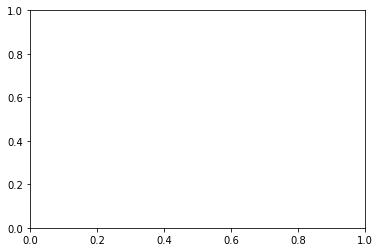

In [94]:
for i in range(4):

    client.fetch_trends(
      msm_id   = 1423187,                   # Atlas measurement ID
      prb_id   = probes[i],                 # Atlas probe ID
      start_dt = utc_datetime(2020, 1, 1),  # (Optional) Default: stop date - 7 days
      stop_dt  = utc_datetime(2020, 1, 15), # (Optional) Default: the current date
      as_df    = True                       # (Optional) Returns a Pandas DataFrame instead of a JSON object
    )

['16 minutes', '23 hours, 12 minutes', '5 days, 8 hours, 48 minutes', '1 day, 19 hours, 49 minutes', '3 hours, 28 minutes', '4 minutes']


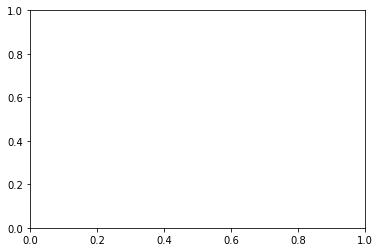

In [93]:
client.fetch_trends(msm_id = 1423187, prb_id = 6030, start_dt = utc_datetime(2020, 1, 1), stop_dt = utc_datetime(2020, 1, 15), as_df = True)

In [92]:
# import datetime as dt

# import numpy as np
# import pandas as pd
# import pytz
# # import datetime as dt
# import time
# import requests
# import math
# import warnings

# import matplotlib.pyplot as plt
# # import numpy as np
# # import pytz
# import seaborn as sns
# from matplotlib.dates import DateFormatter, HourLocator
# from pandas.plotting import register_matplotlib_converters
# from scipy.stats import gaussian_kde

# count = dict()



# class AtlasTrendsQuery:

#     def __init__(self, resource, msm_id, prb_id, start_dt=None, stop_dt=None, subresource=None):
#         self.resource = resource
#         self.subresource = subresource
#         self.msm_id = msm_id
#         self.prb_id = prb_id

#         if stop_dt is None:
#             stop_dt = dt.datetime.now()

#         if start_dt is None:
#             start_dt = stop_dt - dt.timedelta(days=7)

#         self.start_dt = start_dt
#         self.stop_dt = stop_dt

#     def path(self):
#         p = '/{}/{}/{}'.format(self.resource, self.msm_id, self.prb_id)
#         if self.subresource != None:
#             p = p + '/{}'.format(self.subresource)
#         return p

#     def params(self):
#         return {
#             'start': int(self.start_dt.timestamp()),
#             'stop': int(self.stop_dt.timestamp())
#         }

#     def estimated_time(self):
#         """
#         Heuristic for estimating the response time of a query, in seconds.
#         """
#         if self.resource == 'ticks':
#             k = 3150
#         else:
#             k = 450
#         interval = dt.timedelta(minutes=4)
#         t = 1 + (((self.stop_dt - self.start_dt) / interval) / k)
#         return round(t, 1)




# def add_legend(df, ax=None):
#     if ax is None:
#         ax = plt.gca()

#     Δt = (df.index[1:] - df.index[:-1]).mean() / np.timedelta64(1, 's')
#     mapping, transmat = compute_transition_matrix(df.state)

#     palette = sns.husl_palette(df.state.max(), l=0.7, s=.9)
#     artists, labels = [], []

#     for state in sorted(df.state.unique()):
#         # Ignore division by zero (handled later)
#         with warnings.catch_warnings():
#             warnings.simplefilter('ignore')
#             avg_duration = (
#                 1 / (1 - transmat[mapping[state], mapping[state]])) * Δt

#         if avg_duration == math.inf:
#             avg_duration_str = '∞'
#         else:
#             avg_duration_str = td_format(dt.timedelta(seconds=avg_duration))

#         print(avg_duration_str)     

#         artists.append(plt.Rectangle(
#             (0, 0), 1, 1, color=palette[state-1], alpha=0.6))
#         labels.append('State {}\nAvg. duration\n{}'.format(
#             state, avg_duration_str))
        
#     print("new line")
#     print(labels)    

#     ax.legend(artists, labels, bbox_to_anchor=(
#         0.5, -0.35), ncol=len(artists), loc='center')
    

# def to_dataframe(obj, skip_na=True):
#     df = pd.DataFrame.from_records(
#         obj['results'],
#         columns=obj['metadata']['schema']
#     )
#     df['dt'] = df.timestamp.apply(lambda x: dt.datetime.fromtimestamp(x, pytz.UTC))
#     df.loc[df.status != 0, 'rtt'] = np.nan
#     df.set_index('dt', inplace=True)
#     if skip_na:
#         df = df[df.rtt.first_valid_index():]
#     return df


# def get2(self, query):
#         """
#         API Errors are raised as Python exceptions.
#         """
#         if self.verbose:
#             print('Estimatedoh query time: {}s'.format(query.estimated_time()))
#         wall_time = time.time()
#         res = requests.get(self.base_url + query.path(), params=query.params())
#         query_time = time.time() - wall_time
#         if self.verbose:
#             print('Actual query time: {}s'.format(round(query_time, 1)))
#         obj = res.json()
#         if res.status_code != 200:
#             raise ValueError(obj['message'])
#         return obj


# def fetch_trends(self, msm_id, prb_id, start_dt=None, stop_dt=None, as_df=False):
#         query = AtlasTrendsQuery('trends', msm_id, prb_id, start_dt, stop_dt)
#         #print(type(query))
#         res = self.get2(query)
#         # if as_df:
#         #     count = to_dataframe(res)
#         #     add_legend(count)
#         # else:
#         #     count = res
#         #     add_legend(count)

# # client = AtlasTrendsClient(verbose = True)
# # fetch_trends(client, msm_id = 1423187, prb_id = 6030, start_dt = utc_datetime(2020, 1, 1), stop_dt = utc_datetime(2020, 1, 15), as_df = True)
